#Imports

In [40]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import log, dot, e
from numpy.random import rand
import matplotlib.pyplot as plt
import keras
from keras.datasets import imdb
import tensorflow as tf
from tqdm import tqdm
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.preprocessing.sequence import pad_sequences
from keras import metrics
from sklearn.linear_model import LogisticRegression


# 1 = positive review
# 0 = negative review

# Processing data functions

In [2]:
def fetch(a, b):  # fetch data
  (x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(skip_top=a, num_words=b)

  word_index = keras.datasets.imdb.get_word_index()
  index2word = dict((i + 3, word) for (word, i) in word_index.items())
  index2word[0] = '[pad]'
  index2word[1] = '[bos]'
  index2word[2] = '[oov]'
  x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
  x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])
  return x_train, y_train, x_test, y_test  

def vocabulary(x): #  Create vocabulary for x: x_train / x_test 
  vocabulary = list()
  for text in x:
    tokens = text.split()
    vocabulary.extend(tokens)
  vocabulary = set(vocabulary)
  return vocabulary

def binary_vectors(x, vocabulary): # Create binary vectors for x: x_train / x_test, vocabulary: vocabulary_train / vocabulary_test
  x_binary = list()
  for text in tqdm(x):
    tokens = text.split()
    binary_vector = list()
    for vocab_token in vocabulary:
      if vocab_token in tokens:
        binary_vector.append(1)
      else:
        binary_vector.append(0)
    x_binary.append(binary_vector)
  x_binary = np.array(x_binary)
  return x_binary

# Learning curve and table functions

In [42]:
def accuracy(accuracy, y, y_pred):
    N = len(y) # number of examples that are used in every iteration of the experiment

    acc = 0 # number of accurate predictions

    for i in range(len(y_pred)):
      if(y[i] == y_pred[i]):
        acc = acc + 1

    acc = 100* acc/N  #calculating accuracy
    acc = acc * 100
    accuracy.append(acc)
    return accuracy

def precision(precision, y, y_pred):
  pr = 0
  #The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives
  #The precision is intuitively the ability of the classifier not to label as positive a sample that is negative
 
  tp = 0 # tp = number of true positives
  fp = 0 # fp = number of false positives

  for i in range(len(y)):
    if y_pred[i] == 1:
      if y[i] == 1:
        tp += 1
      else:
        fp += 1
    
  pr = tp / (tp + fp) #calculate precision
  precision.append(pr)
  return precision

def recall(recall, y, y_pred):
  rc = 0
  #The recall is the ratio tp / (tp + fn) where fn is the number of false negatives
  #The recall is intuitively the ability of the classifier to find all the positive samples.
  tp = 0 # tp = number of true positives
  fn = 0 # fn = number of false negatives

  for i in range(len(y)):
    if y_pred[i] == 1:
      if y[i] == 1:
        tp += 1
    else:
      if y[i] == 1:
        fn += 1

  rc = tp / (tp + fn) #calculate recall
  recall.append(rc)
  return recall

def F1(F1, pr, rc):
  #The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value
  #at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. 
  #The formula for the F1 score is:
  #F1 = 2 * (precision * recall) / (precision + recall)
  f1 = 2 * (pr[-1] * rc[-1])/(pr[-1] + rc[-1])
  F1.append(f1)
  return F1  

In [29]:
def learningcurve(quality_train, quality_test, examples, label): #creates learningcurve
  # plotting the line 1 points
  plt.plot(examples, quality_train, label = label +" on train data")
  # plotting the line 2 points
  plt.plot(examples, quality_test, label = label +" on test data")
  
  # naming the x axis
  plt.xlabel('number of train/test examples')
  # naming the y axis
  plt.ylabel(label)
  # giving a title to my graph
  plt.title('Learning curve')
  
  # show a legend on the plot
  plt.legend()
  plt.tick_params(axis='x', pad=25)
  # function to show the plot
  plt.show()

def table(array, label): #creates table
  fig, ax = plt.subplots()
  ax.axis('off')
  ccolors = plt.cm.BuPu(np.full(3, 0.1))
  column_headers = ['number of examples', label+' on train data', label+' on test data']
  table = plt.table(cellText= array,
                      rowLabels= None,
                      rowColours=None,
                      cellLoc = 'center',
                      rowLoc='center',
                      colColours=ccolors,
                      colLoc='center',
                      colLabels=column_headers,
                      loc='center')
  plt.show()

def calculate(y, y_pred, acc, pr, rc, f1): # calls the accyracy, precision, recall, F1 functions
  qualities = ['accuracy(%)', 'precision', 'recall', 'F1']
  for quality in qualities: 
    if quality == 'accuracy(%)':
      acc = accuracy(acc, y, y_pred)
    if quality == 'precision':
      pr = precision(pr, y, y_pred)
    if quality == 'recall':
      rc = recall(rc, y, y_pred)
    if quality == 'F1':
      f1 = F1(f1, pr, rc)
  return acc, pr, rc, f1

def reform(examples, quality_train, quality_test): # prepares the data to fit the table 
  table = list()
  for i in range(len(examples)):
    row = list()
    row.append(examples[i])
    row.append(quality_train[i])
    row.append(quality_test[i])
    table.append(row)
  return table

def results(examples, acc_train, pr_train, rc_train, f1_train, acc_test, pr_test, rc_test, f1_test): # calls the learningcurve() and table() functions
  qualities = ['accuracy(%)', 'precision', 'recall', 'F1']
  for quality in qualities: # print learning curves and tables 
    if quality == 'accuracy(%)':
      learningcurve(acc_train, acc_test, examples, quality)
      acc = reform(examples, acc_train, acc_test) # create accuracy(%) list
      table(acc, quality) 
    if quality == 'precision':
      learningcurve(pr_train, pr_test, examples, quality)
      pr = reform(examples, pr_train, pr_test) # create precision list
      table(pr, quality)
    if quality == 'recall':
      learningcurve(rc_train, rc_test, examples, quality)
      rc = reform(examples, rc_train, rc_test) # create recall list
      table(rc, quality)
    if quality == 'F1':
      learningcurve(f1_train, f1_test, examples, quality)
      f1 = reform(examples, f1_train, f1_test) # create F1 list
      table(f1, quality)

# Naive Bayes class



In [5]:
class BernoulliNB(object):
    def __init__(self, alpha=1.0): # alpha = smoothing parameter (helps with handling exceptions such as log0)
        self.alpha = alpha

    def fit(self, X, y):
        count_sample = X.shape[0]
        separated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)] # group  data by class
        self.class_log_prior_ = [np.log(len(i) / count_sample) for i in separated] # calculate logp^(c), the prior log probability for each class
        count = np.array([np.array(i).sum(axis=0) for i in separated]) + self.alpha # count each word for each class and add self.alpha as smoothing
        smoothing = 2 * self.alpha
        n_doc = np.array([len(i) + smoothing for i in separated]) # n_doc = number of documents in each class
        self.feature_prob_ = count / n_doc[np.newaxis].T #calculate the log probability of each word, logp^(t|c). Division of count by the length of text:
        return self

    def predict_log_proba(self, X): # outputs the log probability of each class (self.class_log_prior_ and self.feature_log_prob_ is used for the calculation)
        return [(np.log(self.feature_prob_) * x + \
                np.log(1 - self.feature_prob_) * np.abs(x - 1)
                ).sum(axis=1) + self.class_log_prior_ for x in X]

    def predict(self, X): # predict calls self.predict_log_proba() and picks the maximum value
        return np.argmax(self.predict_log_proba(X), axis=1) # argmax to returns the corresponding index


# ID3 class

In [6]:
class ID3:

    def partition(self, x):  
      s={}
      for v in np.unique(x):
        s.update({v: (x == v).nonzero()[0]})
      return s

    def entropy(self, y):
      values,counts=np.unique(y,return_counts=True)
      h=0
      for i in range(len(values)):
          p=counts[i]/len(y)
          h-=p*math.log2(p)
      return h
      raise Exception('Function not yet implemented!')

    def information_gain(self, x, y):
      hy= self.entropy(y)
      x_vals,counts=np.unique(x,return_counts=True)
      px= counts/len(x)
      mapped=zip(px,x_vals)
      for i,v in mapped:
        hy-=i* self.entropy(y[x==v])
      return hy
        
      raise Exception('Function not yet implemented!')


    def id3(self, x, y, attribute_value_pairs=None, depth=0, max_depth = 5):
      tree = {}
      if attribute_value_pairs is None:
          attribute_value_pairs = np.vstack([[(i, v) for v in np.unique(x[:, i])] for i in range(x.shape[1])]) 
      y_values, y_counts = np.unique(y, return_counts=True) # y_values = [0, 1], y_counts = [number of 0's, numbers of 1's]

      if len(y_values) == 1:
          return y_values[0]
      if len(attribute_value_pairs) == 0 or depth == max_depth:
          return y_values[np.argmax(y_counts)]
      info_gain = np.array([self.information_gain(np.array(x[:, i] == v).astype(int), y)
                                  for (i, v) in attribute_value_pairs])
      (attr, value) = attribute_value_pairs[np.argmax(info_gain)]
      partitions = self.partition(np.array(x[:, attr] == value).astype(int))
      attribute_value_pairs = np.delete(attribute_value_pairs, np.argwhere(np.all(attribute_value_pairs == (attr, value), axis=1)), 0)

      for split_value, indices in partitions.items():
          x_subset = x.take(indices, axis=0)
          y_subset = y.take(indices, axis=0)
          decision = bool(split_value)

          tree[(attr, value, decision)] = self.id3(x_subset, y_subset, attribute_value_pairs=attribute_value_pairs,
                                              max_depth=max_depth, depth=depth + 1)

      return tree

    def predict(self, x, tree):
      for split_criterion, sub_trees in tree.items():
          attribute_index = split_criterion[0]
          attribute_value = split_criterion[1]
          split_decision = split_criterion[2]

          if split_decision == (np.any(x[attribute_index] == attribute_value)):
              if type(sub_trees) is dict:
                  label = self.predict(x, sub_trees)
              else:
                  label = sub_trees

              return label
      raise Exception('Could not predict example with this tree.')


    def pretty_print(self, tree, depth=0): # print root and nodes of the tree
        
      if depth == 0:
          print('TREE')
      for index, split_criterion in enumerate(tree):
          sub_trees = tree[split_criterion]
          print('|\t' * depth, end='')
          print('+-- [SPLIT: x{0} = {1} {2}]'.format(split_criterion[0], split_criterion[1], split_criterion[2]))

          if type(sub_trees) is dict:
              self.pretty_print(sub_trees, depth + 1)
          else:
              print('|\t' * (depth + 1), end='')
              print('+-- [LABEL = {0}]'.format(sub_trees))


    def visualize(self, tree, dot_string='', parent='', nid=-1, depth=0): # visualize the tree

        nid += 1

        if depth == 0:
            dot_string += 'digraph TREE {\n'

        for split_criterion in tree:
              sub_trees = tree[split_criterion]
              print(split_criterion)
              attribute_index = split_criterion[0]
              attribute_value = split_criterion[1]
              split_decision = split_criterion[2]

              if type(sub_trees) is dict:
                  if split_decision:
                      node_id = 'node{0}'.format(nid)
                      dot_string, left_child, nid = self.visualize(sub_trees, dot_string=dot_string,
                                                              parent=node_id, nid=nid, depth=depth+1)
                      dot_string += '    {0} -> {1} [label="True"];\n'.format(node_id, left_child)
                  else:
                      node_id = 'node{0}'.format(nid)
                      dot_string += '    {0} [label="x{1} = {2}?"];\n'.format(node_id, attribute_index, attribute_value)
                      dot_string, right_child, nid = self.visualize(sub_trees, dot_string=dot_string,
                                                              parent=node_id, nid=nid, depth=depth + 1)
                      dot_string += '    {0} -> {1} [label="False"];\n'.format(node_id, right_child)
              else:
                  node_id = 'node{0}'.format(nid)
                  dot_string += '    {0} [label="y = {1}"];\n'.format(node_id, sub_trees)

        if depth == 0:
              dot_string += '}\n'
              return dot_string
        else:
              return dot_string, node_id, nid
        
        

# Logistic Regression class

In [34]:
class Logistic_Regression:
    def __init__(self, alpha=1.0): # alpha = smoothing parameter (helps with handling exceptions such as log0)
      self.alpha = alpha
    def sigmoid(self, z): return 1 / (1 + e**(-z))
    
    def cost_function(self, X, y, weights):                 
        z = dot(X, weights)        
        predict_1 = y * log(self.sigmoid(z))
        predict_0 = (1 - y) * log(1 - self.sigmoid(z))        
        return -sum(predict_1 + predict_0) / len(X)
    
    def fit(self, X, y, epochs=25, lr=0.05):        
        loss = []
        weights = rand(X.shape[1])
        N = len(X)
                 
        for _ in range(epochs):        
            # Gradient Descent
            y_hat = self.sigmoid(dot(X, weights))
            weights += lr * dot(X.T, y - y_hat) / N            
            # Saving Progress
            loss.append(self.cost_function(X, y, weights)) 
            
        self.weights = weights
        self.loss = loss
    
    def predict(self, X):        
    
        # Predicting with sigmoid function
        z = dot(X, self.weights)
        # Returning binary result
        return [1 if i > 0.5 else 0 for i in self.sigmoid(z)]

# Main

In [43]:
# initialize parameters and lists
a = 20 # consider the top 5,000 most common words, but eliminate the top 20 most common words".
b = 200
c = 0.5  # regularization parameter for logistic regression
examples = list()

acc_train = list()
pr_train = list()
rc_train = list()
f1_train = list()

acc_test = list()
pr_test = list()
rc_test = list()
f1_test = list()
i = 0
x0_train, y0_train, x0_test, y0_test = fetch(a, b) #fetch data
print("This program classifies movies from the imdb dataset as positive/negative using machine learning algorithms.\nThen it produces learning curves and tables from the data produced")
print("1) Bernoulli Naive bayes algorithm \n"+
      "2) ID3 decision tree classifier algorithm \n"+
      "3) Logistic regression algorithm\n"+
      "4) Logistic regression by sklearn (for comparison purposes)")
i = input("Enter a number from 1 to 4 to pick the machine learning algorithm you want to apply for the classification:")
i = int(i)

This program classifies movies from the imdb dataset as positive/negative using machine learning algorithms.
Then it produces learning curves and tables from the data produced
1) Bernoulli Naive bayes algorithm 
2) ID3 decision tree classifier algorithm 
3) Logistic regression algorithm
4) Logistic regression by sklearn (for comparison purposes)
Enter a number from 1 to 4 to pick the machine learning algorithm you want to apply for the classification:1


100%|██████████| 1000/1000 [00:00<00:00, 1385.35it/s]


1000


100%|██████████| 3000/3000 [00:02<00:00, 1378.30it/s]


3000


100%|██████████| 5000/5000 [00:03<00:00, 1438.02it/s]


5000


100%|██████████| 7000/7000 [00:04<00:00, 1404.76it/s]


7000


100%|██████████| 9000/9000 [00:06<00:00, 1418.32it/s]


9000


100%|██████████| 11000/11000 [00:08<00:00, 1289.08it/s]


11000


100%|██████████| 13000/13000 [00:09<00:00, 1317.63it/s]


13000


100%|██████████| 15000/15000 [00:13<00:00, 1122.71it/s]


15000


100%|██████████| 17000/17000 [00:12<00:00, 1391.12it/s]


17000


100%|██████████| 19000/19000 [00:13<00:00, 1383.28it/s]


19000


100%|██████████| 21000/21000 [00:15<00:00, 1384.67it/s]


21000


100%|██████████| 23000/23000 [00:16<00:00, 1400.18it/s]


23000


100%|██████████| 25000/25000 [00:17<00:00, 1416.74it/s]


25000


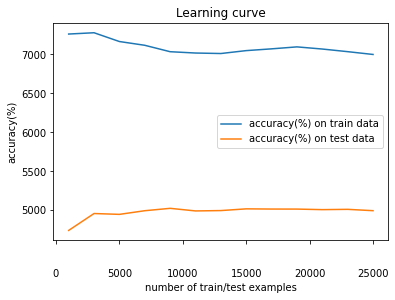

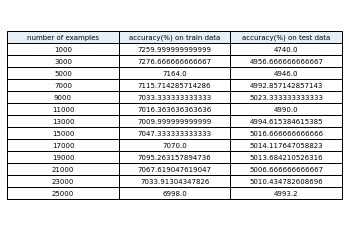

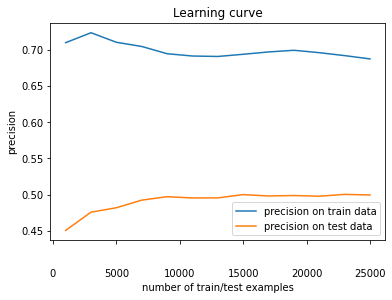

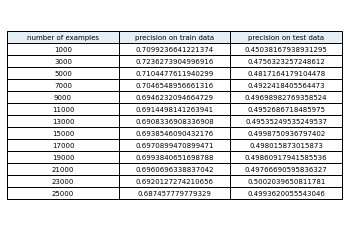

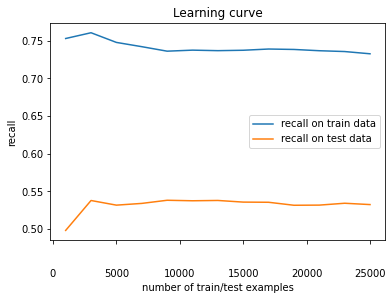

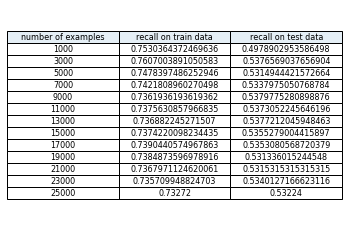

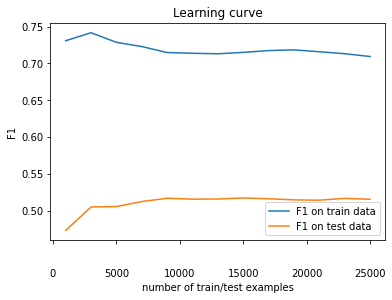

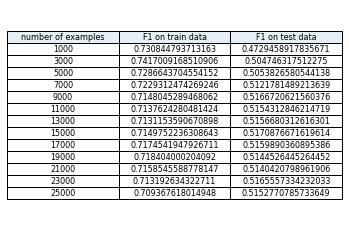

In [44]:
# για αποφυγή μεγάλης διάρκειας εκτέλεσης των αλγορίθμων αλλάξτε το βήμα από 2000 σε 4000 ή 8000
for n in range(1000, 25001, 2000): # n = number of examples
  # limit the number of examples to n for both training and testing data
  x_train = x0_train[:n]
  y_train = y0_train[:n]
  x_test = x0_test[:n]
  y_test = y0_test[:n]

  vocabulary_train = vocabulary(x_train) # create the vocabulary for training data
  vocabulary_test = vocabulary(x_test) # create the vocabulary for testing data

  x_train_binary = binary_vectors(x_train, vocabulary_train) # create binary vectors for training data
  x_test_binary = binary_vectors(x_test, vocabulary_train) # create binary vectors for testing data

  dim_train = np.shape(x_train_binary)
  dim_test = np.shape(x_test_binary)

  if dim_train[1] > dim_test[1]:
    # pad sequence
    x_test_binary = pad_sequences(x_train_binary, maxlen= dim_train[1], padding='post')
  else:
    # truncate sequence
    x_test_binary = pad_sequences(x_train_binary, maxlen= dim_train[1], truncating='post')

  if(i == 0):
    print("No answer was given")
  if(i == 1):
    nb = BernoulliNB()
    nb.fit(x_train_binary, y_train)   
    y_pred_train = nb.predict(x_train_binary)  # prediction for training data
    y_pred_test = nb.predict(x_test_binary)  # prediction for testing data
  if(i == 2):
    decision_tree = ID3()
    tree = decision_tree.id3(x_train_binary, y_train, max_depth= 11)
    #decision_tree.pretty_print(tree)
    #dot = decision_tree.visualize(tree)
    #print(dot)
    y_pred_train = [decision_tree.predict(x, tree) for x in x_train_binary]  #prediction for training data
    y_pred_test = [decision_tree.predict(x, tree) for x in x_test_binary]  #prediction for testing data
  if(i == 3):
    logreg = Logistic_Regression() 
    logreg.fit(x_train_binary, y_train, epochs=500, lr= c)
    y_pred_train = logreg.predict(x_train_binary) #prediction for training data
    y_pred_test = logreg.predict(x_test_binary) # prediction for testing data
  if(i == 4): 
    logistic_regression = LogisticRegression()
    logistic_regression.fit(x_train_binary, y_train)
    y_pred_train = logistic_regression.predict(x_train_binary)  # prediction for training data
    y_pred_test = logistic_regression.predict(x_test_binary)  # prediction for testing data
  if(i > 0 and i <= 4):
    # calculate accuracy(%), precision, recall, f1 score for training and testing data 
    acc_train, pr_train, rc_train, f1_train = calculate(y_train, y_pred_train, acc_train, pr_train, rc_train, f1_train) 
    acc_test, pr_test, rc_test, f1_test = calculate(y_test, y_pred_test, acc_test, pr_test, rc_test, f1_test)
    print(n)
  examples.append(n)
if n == 25000:
  results(examples, acc_train, pr_train, rc_train, f1_train, acc_test, pr_test, rc_test, f1_test)   
